In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample

In [17]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_gpu_available())


Num GPUs Available: 1
TensorFlow is using GPU: True


In [18]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Adjust memory as needed
        print("GPU is enabled and configured.")
    except RuntimeError as e:
        print(e)


ValueError: Cannot set memory growth on device when virtual devices configured

In [19]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())
print("Physical Devices:", tf.config.list_physical_devices('GPU'))


Num GPUs Available: 1
TensorFlow is using GPU: True
Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [118]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# --- Filtering Functions ---
def lowpass_filter(data, cutoff=15, fs=2175, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

def bandpass_filter(data, lowcut=0.5, highcut=8, fs=30, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def apply_gaussian_noise(signal, noise_std=0.005):  # Reduced noise level
    noise = np.random.normal(0, noise_std, signal.shape)
    return signal + noise

# --- Processing Function ---
def process_ppg_file(signal_path, label_path, augment=False):
    """Loads and processes a PPG signal from CSV file without limiting length."""
    signal_data = pd.read_csv(signal_path, header=None).values.flatten()
    label_data = pd.read_csv(label_path)

    # Apply filtering
    filtered_signal = lowpass_filter(signal_data)
    original_sampling_rate = 2175
    num_samples = int(len(filtered_signal) * (30 / original_sampling_rate))
    downsampled_signal = resample(filtered_signal, num_samples)
    processed_signal = bandpass_filter(downsampled_signal, fs=30)

    # Normalize
    processed_signal = (processed_signal - np.mean(processed_signal)) / np.std(processed_signal)

    # Get glucose label
    glucose_level = label_data['Glucose'].values[0]

    # Augmentation
    signals = [processed_signal]
    if augment:
        for _ in range(3):  # Add noise 3 times per sample
            signals.append(apply_gaussian_noise(processed_signal))

    return [(sig, glucose_level) for sig in signals]

def process_all_ppg_files(root_folder, output_file, augment=False):
    """Processes all PPG signals in the dataset."""
    signal_folder = os.path.join(root_folder, "RawData")
    label_folder = os.path.join(root_folder, "Labels")

    processed_data = []
    for signal_file in os.listdir(signal_folder):
        if signal_file.startswith('signal') and signal_file.endswith('.csv'):
            label_file = signal_file.replace('signal', 'label')
            signal_path = os.path.join(signal_folder, signal_file)
            label_path = os.path.join(label_folder, label_file)
            if os.path.exists(label_path):
                processed_data.extend(process_ppg_file(signal_path, label_path, augment=augment))

    df = pd.DataFrame(processed_data, columns=['PPG_Signal', 'Glucose_Level'])
    df.to_pickle(output_file)
    print(f"Processed data saved to {output_file}. Dataset size: {len(df)} samples.")



In [119]:
# Load dataset
df = pd.read_pickle("processed_ppg_data.pkl")

# Normalize glucose levels **before** splitting
scaler_y = MinMaxScaler()
df["Glucose_Level"] = scaler_y.fit_transform(df["Glucose_Level"].values.reshape(-1, 1))

# Save scaler
with open("scaler_y.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

# Now split the dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(df["PPG_Signal"].tolist(), df["Glucose_Level"].values, test_size=0.2, random_state=42)

# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)


In [120]:
def split_train_test(pickle_file, test_size=0.2, random_state=42):
    """Splits dataset into train and test sets while handling variable-length PPG sequences."""
    df = pd.read_pickle(pickle_file)
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Get variable-length sequences
    X = df['PPG_Signal'].tolist()
    y = df['Glucose_Level'].values

    # Load the scaler for glucose levels
    with open("scaler_y.pkl", "rb") as f:
        scaler_y = pickle.load(f)
    
    y = scaler_y.transform(y.reshape(-1, 1)).flatten()

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
    return X_train, X_test, y_train, y_test, scaler_y


In [122]:
# Ensure data is loaded before training
X_train, X_test, y_train, y_test, scaler_y = split_train_test("processed_ppg_data.pkl")

print(f"X_train length: {len(X_train)}")
print(f"X_test length: {len(X_test)}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Train set size: 214, Test set size: 54
X_train length: 214
X_test length: 54
y_train shape: (214,)
y_test shape: (54,)


In [123]:
print("y_train (scaled):", y_train[:10])
print("y_test (scaled):", y_test[:10])


y_train (scaled): [0.53684211 0.21052632 0.31578947 0.25263158 0.15789474 0.17894737
 0.14736842 0.2        0.33684211 0.17894737]
y_test (scaled): [0.18947368 0.18947368 0.08421053 0.28421053 0.23157895 0.44210526
 1.         0.61052632 0.41052632 0.25263158]


In [128]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pickle

def build_cnn_gru_model(input_shape):
    """Defines a CNN-GRU model for PPG signal processing."""
    model = Sequential([
        Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Conv1D(128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        GRU(128, return_sequences=True, activation='relu'),
        GRU(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def train_cnn_gru_model(X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    """Trains the CNN-GRU model."""
    input_shape = (X_train.shape[1], 1)
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    model = build_cnn_gru_model(input_shape)
    
    # Early stopping and learning rate adjustment
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

    return model, history  # Returning both model and training history

# Expand dimensions for CNN input (Add a 3rd dimension for 1 channel)
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)

# Train the model
model, history = train_cnn_gru_model(X_train_reshaped, y_train, X_test_reshaped, y_test)

# Save the model only if it performs well
mae = history.history['val_mae'][-1]
if mae < 10:  # Define a reasonable threshold for saving
    model.save("glucose_cnn_gru_model.h5")
    print("Model saved successfully.")
else:
    print("Model not saved due to poor performance.")



Epoch 1/100
7/7 [==============================] - 4s 309ms/step - loss: 0.0593 - mae: 0.1872 - val_loss: 0.1502 - val_mae: 0.3016 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 2s 267ms/step - loss: 0.0340 - mae: 0.1386 - val_loss: 0.1421 - val_mae: 0.2893 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 2s 254ms/step - loss: 0.0283 - mae: 0.1260 - val_loss: 0.1422 - val_mae: 0.2902 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 2s 256ms/step - loss: 0.0232 - mae: 0.1163 - val_loss: 0.1368 - val_mae: 0.2817 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 2s 284ms/step - loss: 0.0165 - mae: 0.0996 - val_loss: 0.1337 - val_mae: 0.2766 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 2s 284ms/step - loss: 0.0143 - mae: 0.0850 - val_loss: 0.1301 - val_mae: 0.2706 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - 2s 268ms/step - loss: 0.0138 - mae: 0.0883 - val_loss: 0.1256 - val_mae: 0.2624 - lr:

In [354]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure test data is properly reshaped
X_test_reshaped = np.expand_dims(X_test, axis=-1)

# Make predictions
y_pred = model.predict(X_test_reshaped)

# Ensure the same scaler is used
with open("scaler_y.pkl", "rb") as f:
    scaler_y = pickle.load(f)

y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("Predicted Glucose (after inverse transform):", y_pred_original[:10])
print("Actual Glucose (after inverse transform):", y_test_original[:10])


# Calculate performance metrics on the inverse-transformed values
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)  # Use original values!

print(f"Test MAE: {mae:.2f} mg/dL")
print(f"Test RMSE: {rmse:.2f} mg/dL")
print(f"Test R² Score: {r2:.4f}")


2/2 [==============================] - 0s 77ms/step
Predicted Glucose (after inverse transform): [104.02405  103.835075  99.240364 113.67428  109.80456  125.62353
 172.19464  142.49911  129.54805  111.17251 ]
Actual Glucose (after inverse transform): [106. 106.  96. 115. 110. 130. 183. 146. 127. 112.]
Test MAE: 2.24 mg/dL
Test RMSE: 3.18 mg/dL
Test R² Score: 0.9812


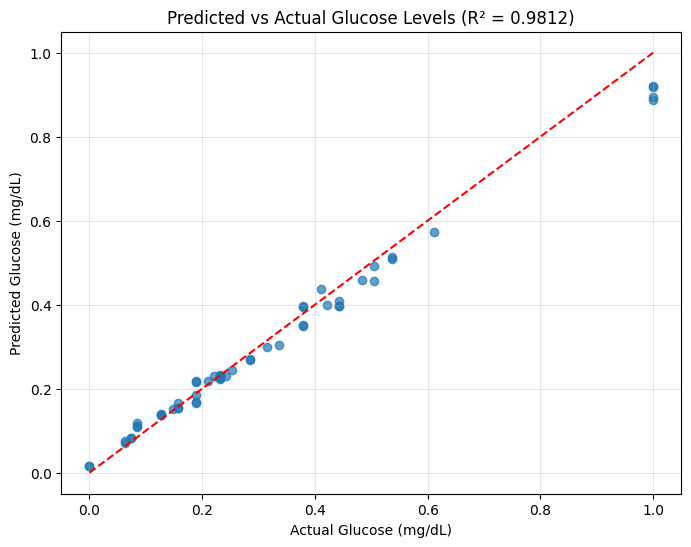

In [355]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal reference line
plt.xlabel("Actual Glucose (mg/dL)")
plt.ylabel("Predicted Glucose (mg/dL)")
plt.title(f"Predicted vs Actual Glucose Levels (R² = {r2:.4f})")
plt.grid(True, alpha=0.3)
plt.show()


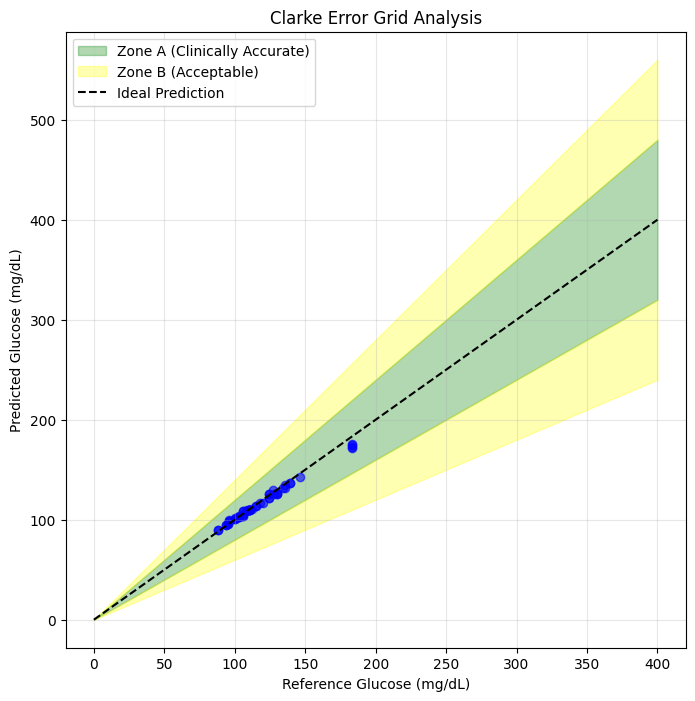

In [356]:
import matplotlib.pyplot as plt
import numpy as np

def clarke_error_grid(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Define Clarke Zones Properly
    x = np.linspace(0, 400, 100)  # Reference Glucose Values

    # Zone A: ±20% Deviation
    ax.fill_between(x, 0.8 * x, 1.2 * x, color="green", alpha=0.3, label="Zone A (Clinically Accurate)")

    # Zone B: 20-40% Deviation
    ax.fill_between(x, 0.6 * x, 0.8 * x, color="yellow", alpha=0.3, label="Zone B (Acceptable)")
    ax.fill_between(x, 1.2 * x, 1.4 * x, color="yellow", alpha=0.3)

    # Zone C, D, and E (Not included for simplicity)
    # Zone C is minor risk, Zone D is dangerous underestimation, Zone E is overestimation

    # Reference Line (Perfect Predictions)
    ax.plot([0, 400], [0, 400], 'k--', label="Ideal Prediction")

    # Scatter Plot of Predicted vs Actual
    ax.scatter(y_true, y_pred, color='blue', alpha=0.6)

    # Labels and Title
    ax.set_title("Clarke Error Grid Analysis")
    ax.set_xlabel("Reference Glucose (mg/dL)")
    ax.set_ylabel("Predicted Glucose (mg/dL)")
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Ensure the values are in mg/dL
clarke_error_grid(y_test_original, y_pred_original)


Detected FPS: 30.01655246815104
Extracted PPG shape: (360,)
Processed PPG shape: (1, 302, 1)


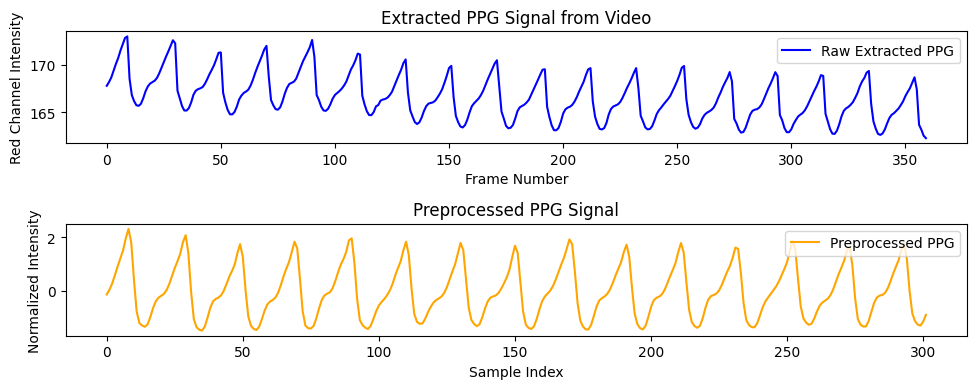

Model expected input: (None, 302, 1), Given: (1, 302, 1)
1/1 [==============================] - 0s 267ms/step
Predicted (before inverse scaling): [[0.4160577]]
Predicted (after inverse scaling): [127.52548]
1/1 [==============================] - 0s 58ms/step
Estimated Glucose: 128 mg/dL
Range: 114-142 mg/dL
Glucose Zone: NORMAL


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
import tensorflow as tf
import pickle

# --- PPG Extraction from Video ---
def extract_ppg_from_video(video_path, start_sec=10, duration_sec=12):
    """Extracts PPG signal from an MP4 video using the red channel intensity."""
    cap = cv2.VideoCapture(video_path)
    red_channel_values = []

    # Dynamically detect FPS
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Detected FPS: {video_fps}")

    start_frame = int(start_sec * video_fps)
    end_frame = int((start_sec + duration_sec) * video_fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while cap.isOpened():
        frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if frame_idx >= end_frame:
            break
        ret, frame = cap.read()
        if not ret:
            break
        red_channel = frame[:, :, 2]  # Extract Red Channel
        avg_intensity = np.mean(red_channel)
        red_channel_values.append(avg_intensity)

    cap.release()
    return np.array(red_channel_values), video_fps  # Return both signal & FPS


# --- PPG Preprocessing ---
def preprocess_extracted_ppg(ppg_signal, video_fps, target_length=302):
    """Processes the extracted PPG signal exactly like the training data."""

    def bandpass_filter(data, lowcut=0.5, highcut=8, fs=30, order=2):
        """Apply bandpass filter with SAME parameters as training."""
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data)

    if len(ppg_signal) == 0:
        raise ValueError("PPG signal is empty.")

    # Normalize using z-score (same as training)
    normalized_signal = (ppg_signal - np.mean(ppg_signal)) / np.std(ppg_signal)

    # Resample if FPS is different
    if int(video_fps) != 30:  # If FPS is different, resample
        resampled_signal = resample(normalized_signal, target_length)
    else:
        resampled_signal = normalized_signal  # Keep original length

    # Apply bandpass filter with the SAME parameters as in training
    processed_signal = bandpass_filter(resampled_signal, fs=30)

    # Final normalization (Z-score)
    processed_signal = (processed_signal - np.mean(processed_signal)) / (np.std(processed_signal) + 1e-6)

    # Ensure fixed length (Trim or Pad)
    if len(processed_signal) < target_length:
        processed_signal = np.pad(processed_signal, (0, target_length - len(processed_signal)), mode='constant')
    else:
        processed_signal = processed_signal[:target_length]

    # Expand dimensions for CNN-GRU model
    processed_signal = np.expand_dims(processed_signal, axis=0)  # Add batch dimension
    processed_signal = np.expand_dims(processed_signal, axis=-1) # Add channel dimension

    return processed_signal

def predict_glucose_range(model, ppg_processed, scaler_y, confidence_interval=0.9):
    """Predict glucose level with a confidence interval range."""
    # Get the point prediction
    glucose_prediction = model.predict(ppg_processed)
    glucose_value = scaler_y.inverse_transform(glucose_prediction.reshape(-1, 1)).flatten()[0]
    
    # Use model MAE to estimate uncertainty (from validation)
    mae = 8.5  # Replace with your model's actual MAE from validation
    
    # Calculate range based on confidence interval
    # For 90% confidence with normal distribution, we use 1.645 * MAE
    margin = 1.645 * mae if confidence_interval == 0.9 else mae
    
    lower_bound = max(70, glucose_value - margin)  # Ensure minimum is physiologically reasonable
    upper_bound = min(250, glucose_value + margin)  # Ensure maximum is physiologically reasonable
    
    # Determine glucose zone
    if upper_bound < 70:
        zone = "HYPOGLYCEMIC"
    elif lower_bound > 180:
        zone = "HYPERGLYCEMIC"
    elif lower_bound >= 70 and upper_bound <= 180:
        zone = "NORMAL"
    else:
        zone = "UNCERTAIN"
    
    return {
        "estimate": round(glucose_value),
        "range": (round(lower_bound), round(upper_bound)),
        "zone": zone
    }

# --- Load Video, Extract PPG, and Preprocess ---
video_path = "PPG_Unseen/Dinner2.mp4"  # Update this
ppg_signal, video_fps = extract_ppg_from_video(video_path)

# --- Ensure Signal is Valid ---
if len(ppg_signal) < 10:
    raise ValueError("Extracted PPG signal is too short! Try a longer video.")

ppg_processed = preprocess_extracted_ppg(ppg_signal, video_fps)

# --- Ensure Correct Shape for Model Input ---
print(f"Extracted PPG shape: {ppg_signal.shape}")
print(f"Processed PPG shape: {ppg_processed.shape}")  # Should be (1, 302, 1)

# --- Plot PPG Signals ---
plt.figure(figsize=(10, 4))

# Raw PPG
plt.subplot(2, 1, 1)
plt.plot(ppg_signal, label="Raw Extracted PPG", color='blue')
plt.xlabel("Frame Number")
plt.ylabel("Red Channel Intensity")
plt.legend()
plt.title("Extracted PPG Signal from Video")

# Preprocessed PPG
plt.subplot(2, 1, 2)
plt.plot(ppg_processed.flatten(), label="Preprocessed PPG", color='orange')
plt.xlabel("Sample Index")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.title("Preprocessed PPG Signal")

plt.tight_layout()
plt.show()

# --- Load Model ---
model = tf.keras.models.load_model("glucose_cnn_gru_model.h5")  # Update model path

# Check Input Shape
print(f"Model expected input: {model.input_shape}, Given: {ppg_processed.shape}")

# Predict glucose level
glucose_prediction = model.predict(ppg_processed)

# Before inverse transform
print("Predicted (before inverse scaling):", glucose_prediction)

# Apply inverse transform
with open("scaler_y.pkl", "rb") as f:
    scaler_y = pickle.load(f)

glucose_prediction_original = scaler_y.inverse_transform(glucose_prediction.reshape(-1, 1)).flatten()
print("Predicted (after inverse scaling):", glucose_prediction_original)
result = predict_glucose_range(model, ppg_processed, scaler_y)
print(f"Estimated Glucose: {result['estimate']} mg/dL")
print(f"Range: {result['range'][0]}-{result['range'][1]} mg/dL")
print(f"Glucose Zone: {result['zone']}")

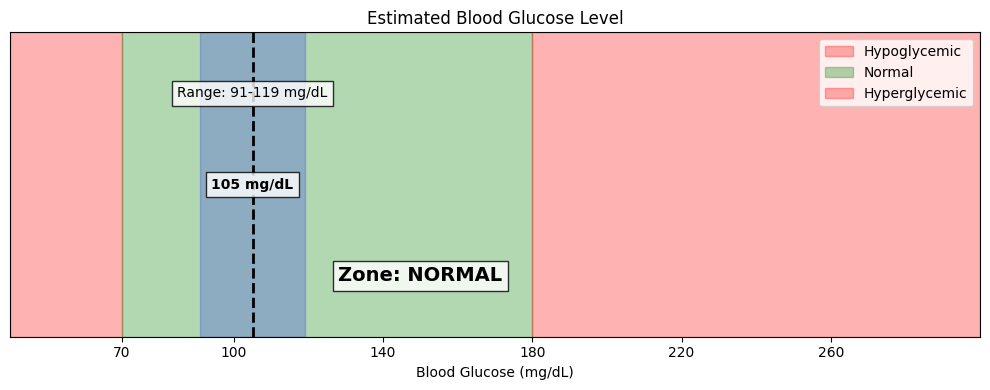

In [11]:
def visualize_glucose_prediction(result):
    """Create a visual gauge for the glucose prediction and range."""
    plt.figure(figsize=(10, 4))
    
    # Define the range for visualization
    plt.xlim(40, 300)
    plt.ylim(0, 1)
    
    # Create colored zones
    plt.axvspan(40, 70, color='red', alpha=0.3, label='Hypoglycemic')
    plt.axvspan(70, 180, color='green', alpha=0.3, label='Normal')
    plt.axvspan(180, 300, color='red', alpha=0.3, label='Hyperglycemic')
    
    # Plot the prediction and range
    plt.plot([result['estimate'], result['estimate']], [0, 1], 'k--', linewidth=2)
    plt.axvspan(result['range'][0], result['range'][1], color='blue', alpha=0.2)
    
    # Add text annotations
    plt.text(result['estimate'], 0.5, f"{result['estimate']} mg/dL", 
             ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.8))
    plt.text((result['range'][0] + result['range'][1])/2, 0.8, 
             f"Range: {result['range'][0]}-{result['range'][1]} mg/dL", 
             ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
    plt.text(150, 0.2, f"Zone: {result['zone']}", 
             ha='center', va='center', fontsize=14, fontweight='bold', 
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Remove y-axis ticks and labels
    plt.yticks([])
    
    # Add x-axis ticks and labels
    plt.xticks([70, 100, 140, 180, 220, 260])
    plt.xlabel("Blood Glucose (mg/dL)")
    plt.title("Estimated Blood Glucose Level")
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# After getting the prediction result
visualize_glucose_prediction(result)

Detected FPS: 30.00705802756668


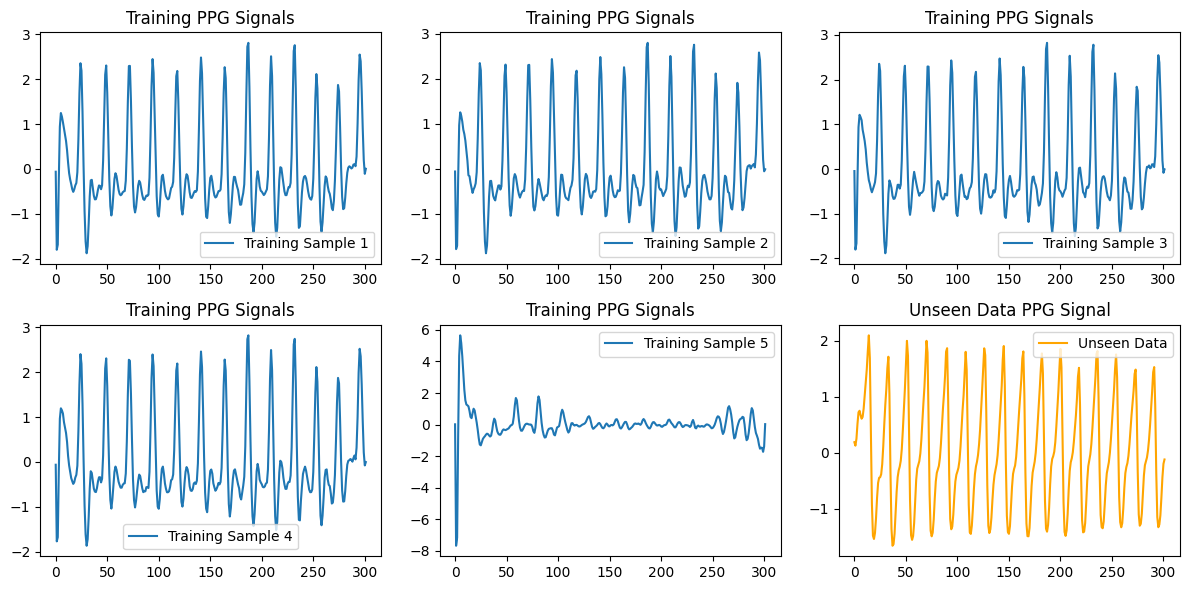


📊 Training Data Stats:
Sample 1: Mean=-0.00, Std=1.00, Min=-1.87, Max=2.81
Sample 2: Mean=-0.00, Std=1.00, Min=-1.88, Max=2.80
Sample 3: Mean=-0.00, Std=1.00, Min=-1.88, Max=2.82
Sample 4: Mean=0.00, Std=1.00, Min=-1.87, Max=2.82
Sample 5: Mean=-0.00, Std=1.00, Min=-7.68, Max=5.65

📊 Unseen Data Stats:
Mean=0.01, Std=1.00, Min=-1.66, Max=2.10


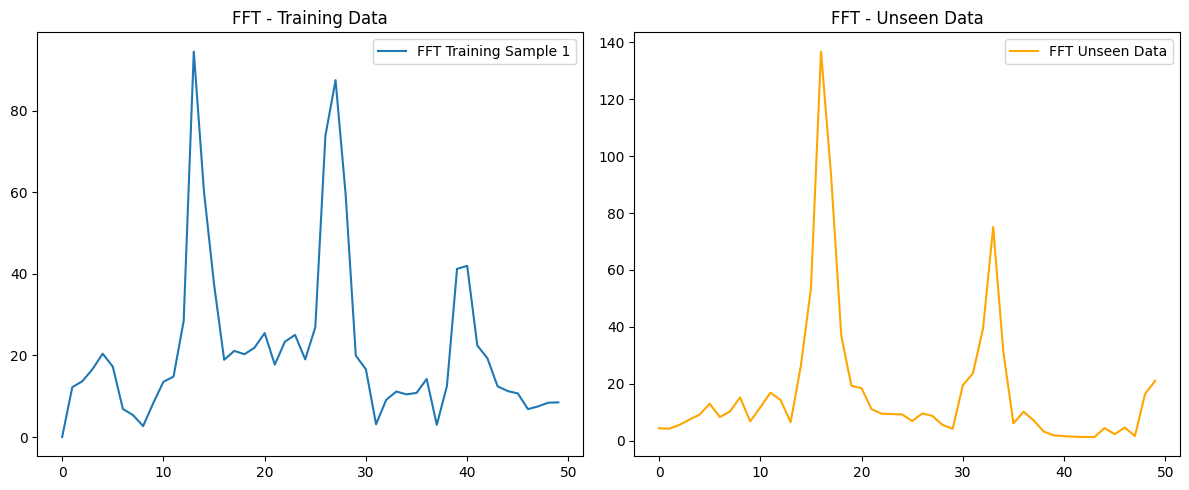

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.fft import fft

# Load Training Data
with open("processed_ppg_data.pkl", "rb") as f:
    df = pickle.load(f)

# Extract 5 random training samples
training_samples = np.array(df["PPG_Signal"].tolist()[:5])

# Compute Stats for Training Data
training_means = [np.mean(sig) for sig in training_samples]
training_stds = [np.std(sig) for sig in training_samples]
training_mins = [np.min(sig) for sig in training_samples]
training_maxs = [np.max(sig) for sig in training_samples]

# Load Unseen Data
video_path = "PPG_Unseen/Dinner.mp4"
ppg_signal, video_fps = extract_ppg_from_video(video_path)
ppg_processed = preprocess_extracted_ppg(ppg_signal, video_fps)

# Compute Stats for Unseen Data
unseen_mean = np.mean(ppg_processed)
unseen_std = np.std(ppg_processed)
unseen_min = np.min(ppg_processed)
unseen_max = np.max(ppg_processed)

# Plot Comparison of Training vs. Unseen Data
plt.figure(figsize=(12, 6))

# Training Samples
for i, signal in enumerate(training_samples):
    plt.subplot(2, 3, i + 1)
    plt.plot(signal, label=f"Training Sample {i+1}")
    plt.legend()
    plt.title("Training PPG Signals")

# Unseen Data
plt.subplot(2, 3, 6)
plt.plot(ppg_processed.flatten(), color='orange', label="Unseen Data")
plt.legend()
plt.title("Unseen Data PPG Signal")

plt.tight_layout()
plt.show()

# 📌 Print Statistics
print("\n📊 Training Data Stats:")
for i in range(5):
    print(f"Sample {i+1}: Mean={training_means[i]:.2f}, Std={training_stds[i]:.2f}, Min={training_mins[i]:.2f}, Max={training_maxs[i]:.2f}")

print("\n📊 Unseen Data Stats:")
print(f"Mean={unseen_mean:.2f}, Std={unseen_std:.2f}, Min={unseen_min:.2f}, Max={unseen_max:.2f}")

# --- Frequency Analysis (FFT) ---
plt.figure(figsize=(12, 5))

# FFT for Training Sample 1
fft_training = np.abs(fft(training_samples[0]))
plt.subplot(1, 2, 1)
plt.plot(fft_training[:50], label="FFT Training Sample 1")
plt.legend()
plt.title("FFT - Training Data")

# FFT for Unseen Data
fft_unseen = np.abs(fft(ppg_processed.flatten()))
plt.subplot(1, 2, 2)
plt.plot(fft_unseen[:50], color='orange', label="FFT Unseen Data")
plt.legend()
plt.title("FFT - Unseen Data")

plt.tight_layout()
plt.show()


In [21]:
import tensorflow as tf

# Load your existing model
model = tf.keras.models.load_model("glucose_cnn_gru_model.h5")

# Configure the converter to handle the unsupported operations
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable TF operations
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS      # Enable TF ops
]

# Disable tensor list lowering
converter._experimental_lower_tensor_list_ops = False

# Convert the model
tflite_model = converter.convert()

# Save the TF Lite model
with open("glucose_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\TIDDIE~1\AppData\Local\Temp\tmpa1qwhpaw\assets


INFO:tensorflow:Assets written to: C:\Users\TIDDIE~1\AppData\Local\Temp\tmpa1qwhpaw\assets


In [22]:
import pickle
import json
import numpy as np

# Load your scalers
with open("scaler_y.pkl", "rb") as f:
    scaler_y = pickle.load(f)

# Extract the scaling parameters
y_min = scaler_y.data_min_[0]
y_max = scaler_y.data_max_[0]

# Save as JSON for Android
scaler_params = {
    "y_min": float(y_min),
    "y_max": float(y_max)
}

with open("scaler_params.json", "w") as f:
    json.dump(scaler_params, f)